# S&P500 with Vanilla RNN and TF API

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('SP500_univariate.csv')

**Normalize**

In [3]:
dataset = (dataset - dataset.mean()) / (dataset.max() - dataset.min())

In [4]:
dataset.head(2)

,CloseFeature,CloseTarget
0,0.039526,0.033640
1,0.033943,0.041311


In [5]:
dataset.tail(2)

,CloseFeature,CloseTarget
4272,0.577965,0.585242
4273,0.588379,0.590354


## Hyperparams

In [6]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 4 #The number of neurons

num_features = 1
num_classes = 1 

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 4274
The current configuration gives us 1424 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [7]:
datasetTrain = dataset[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(dataset.index)):
    
    if(i % truncated_backprop_length == 0):
        test_first_idx = len(dataset.index)-i
        break

datasetTest =  dataset[dataset.index >= test_first_idx]

In [8]:
datasetTrain.tail(2)

,CloseFeature,CloseTarget
4270,0.580258,0.575512
4271,0.578598,0.574882


In [9]:
datasetTest.head(2)

,CloseFeature,CloseTarget
4172,0.496530,0.498390
4173,0.501081,0.493806


In [10]:
xTrain = datasetTrain['CloseFeature'].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [11]:
print(xTrain[0:3],'\n',yTrain[0:3])

[ 0.03952583  0.03394279  0.04165296] 
 [ 0.03364032  0.04131107  0.03581336]


In [12]:
xTest = datasetTest['CloseFeature'].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [13]:
print(xTest[0:3],'\n',yTest[0:3])

[ 0.49652969  0.5010805   0.49647261] 
 [ 0.49839005  0.49380571  0.49380571]


## Visualize starting data

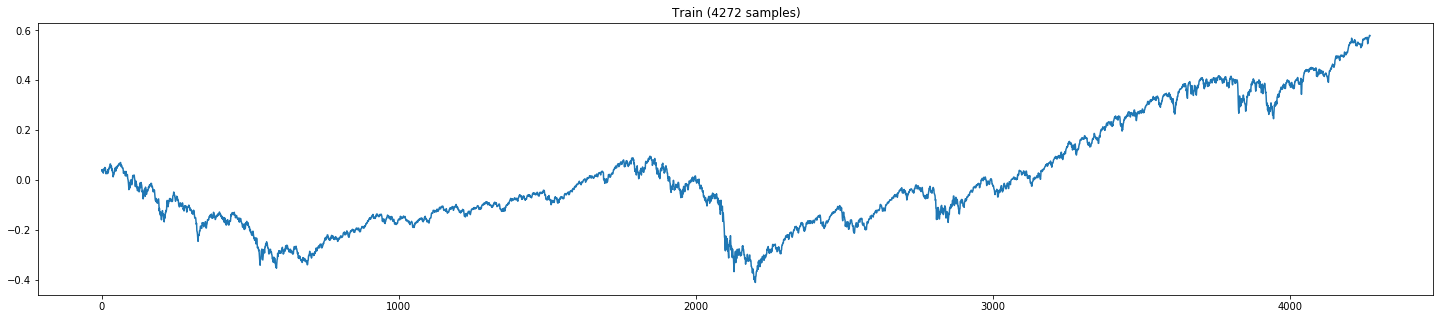

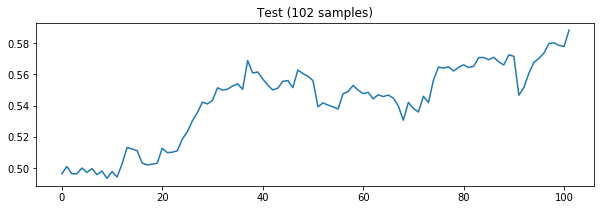

In [14]:
plt.figure(figsize=(25,5))
plt.plot(xTrain)
plt.title('Train (' +str(xTrain.size)+' samples)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest)
plt.title('Test (' +str(xTest.size)+' samples)')
plt.show()

## Placeholder

In [15]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases

Because is a 3 layer net:
 1. Input
 2. Hidden Recurrent layer
 3. Output

We need 2 pairs of W and b

In [16]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [17]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [18]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [19]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [20]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

**Weights and bias** out

In [21]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [22]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [23]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            batchX = xTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,num_features)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(xTest.size - truncated_backprop_length):
        
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,num_features))
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,num_features))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.002835
Step 50 - Loss: 0.004534
Step 100 - Loss: 0.000736
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000454
Step 300 - Loss: 0.000024
Step 350 - Loss: 0.000082
Step 400 - Loss: 0.000081
Step 450 - Loss: 0.000011
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000316
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000888
Step 750 - Loss: 0.000093
Step 800 - Loss: 0.000300
Step 850 - Loss: 0.000065
Step 900 - Loss: 0.000046
Step 950 - Loss: 0.000854
Step 1000 - Loss: 0.000162
Step 1050 - Loss: 0.000001
Step 1100 - Loss: 0.000009
Step 1150 - Loss: 0.000044
Step 1200 - Loss: 0.000639
Step 1250 - Loss: 0.000403
Step 1300 - Loss: 0.000725
Step 1350 - Loss: 0.000383
Step 1400 - Loss: 0.000020
Epoch 1
Step 0 - Loss: 0.038355
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.000028
Step 150 - Loss: 0.000228
Step 200 - Loss: 0.000093
Step 250 - Loss: 0.000024
Step 300 - Loss: 0.000026
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.

Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000013
Step 1200 - Loss: 0.000449
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000618
Step 1350 - Loss: 0.000003
Step 1400 - Loss: 0.000013
Epoch 11
Step 0 - Loss: 0.005927
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000011
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000036
Step 350 - Loss: 0.000093
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000139
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000017
Step 700 - Loss: 0.003426
Step 750 - Loss: 0.000156
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000002
Step 950 - Loss: 0.000242
Step 1000 - Loss: 0.000010
Step 1050 - Loss: 0.000082
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000014
Step 1200 - Loss: 0.000439
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000593
Step 1350 - Loss: 0.000003
Step 1400 - Loss: 0.000014
Epoch 12
Step 0 - Loss: 0.005654
Step 50 -

Step 700 - Loss: 0.002944
Step 750 - Loss: 0.000151
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000006
Step 950 - Loss: 0.000301
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000068
Step 1100 - Loss: 0.000012
Step 1150 - Loss: 0.000023
Step 1200 - Loss: 0.000361
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000405
Step 1350 - Loss: 0.000002
Step 1400 - Loss: 0.000026
Epoch 22
Step 0 - Loss: 0.005703
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000009
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000104
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000026
Step 500 - Loss: 0.000136
Step 550 - Loss: 0.000020
Step 600 - Loss: 0.000490
Step 650 - Loss: 0.000030
Step 700 - Loss: 0.002932
Step 750 - Loss: 0.000150
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000006
Step 950 - Loss: 0.000301
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000068
Step 1100 - Loss: 0.0

Step 300 - Loss: 0.000043
Step 350 - Loss: 0.000090
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000028
Step 500 - Loss: 0.000122
Step 550 - Loss: 0.000025
Step 600 - Loss: 0.000499
Step 650 - Loss: 0.000026
Step 700 - Loss: 0.003116
Step 750 - Loss: 0.000158
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000010
Step 950 - Loss: 0.000319
Step 1000 - Loss: 0.000007
Step 1050 - Loss: 0.000066
Step 1100 - Loss: 0.000012
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.000379
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000460
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000024
Epoch 33
Step 0 - Loss: 0.007466
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000007
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000042
Step 350 - Loss: 0.000097
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000027
Step 500 - Loss: 0.000129
Step 550 - Loss: 0.000022
Step 600 - Loss: 0.000467
Step 650 - Loss: 0.000021
Step 700 - Loss: 0.0033

Step 1300 - Loss: 0.000516
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000023
Epoch 43
Step 0 - Loss: 0.008249
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000008
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000040
Step 350 - Loss: 0.000091
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000133
Step 550 - Loss: 0.000026
Step 600 - Loss: 0.000455
Step 650 - Loss: 0.000011
Step 700 - Loss: 0.003800
Step 750 - Loss: 0.000155
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000002
Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000265
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000075
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.000405
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000523
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000023
Epoch 44
Step 0 - Loss: 0.008364
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000008
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000005
Step 250 - Los

Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000252
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000079
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000018
Step 1200 - Loss: 0.000433
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000596
Step 1350 - Loss: 0.000005
Step 1400 - Loss: 0.000020
Epoch 54
Step 0 - Loss: 0.008673
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000009
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000038
Step 350 - Loss: 0.000088
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000135
Step 550 - Loss: 0.000026
Step 600 - Loss: 0.000438
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.003946
Step 750 - Loss: 0.000157
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000249
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000080
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000018
Step 1200 - Loss: 0

Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000136
Step 550 - Loss: 0.000026
Step 600 - Loss: 0.000430
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.004030
Step 750 - Loss: 0.000157
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000006
Step 950 - Loss: 0.000238
Step 1000 - Loss: 0.000010
Step 1050 - Loss: 0.000082
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000016
Step 1200 - Loss: 0.000445
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000631
Step 1350 - Loss: 0.000005
Step 1400 - Loss: 0.000018
Epoch 65
Step 0 - Loss: 0.008587
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000009
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000038
Step 350 - Loss: 0.000088
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000136
Step 550 - Loss: 0.000026
Step 600 - Loss: 0.000429
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.004039
Step 750 - Loss: 0.000157
Step 800 - Loss: 0.0000

Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000010
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000035
Step 350 - Loss: 0.000095
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000140
Step 550 - Loss: 0.000024
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.004193
Step 750 - Loss: 0.000150
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000004
Step 950 - Loss: 0.000211
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000083
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000016
Step 1200 - Loss: 0.000451
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000624
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000016
Epoch 76
Step 0 - Loss: 0.008138
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000010
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000035
Step 350 - Loss: 0.000096
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.00004

Step 1050 - Loss: 0.000081
Step 1100 - Loss: 0.000009
Step 1150 - Loss: 0.000015
Step 1200 - Loss: 0.000453
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000593
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000014
Epoch 86
Step 0 - Loss: 0.007585
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000011
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000007
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000033
Step 350 - Loss: 0.000100
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000139
Step 550 - Loss: 0.000021
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000012
Step 700 - Loss: 0.003994
Step 750 - Loss: 0.000145
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000002
Step 900 - Loss: 0.000003
Step 950 - Loss: 0.000202
Step 1000 - Loss: 0.000010
Step 1050 - Loss: 0.000080
Step 1100 - Loss: 0.000009
Step 1150 - Loss: 0.000015
Step 1200 - Loss: 0.000454
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000589
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000014
Epoch 87
Step 0

Step 700 - Loss: 0.003952
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000002
Step 900 - Loss: 0.000002
Step 950 - Loss: 0.000187
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000081
Step 1100 - Loss: 0.000009
Step 1150 - Loss: 0.000017
Step 1200 - Loss: 0.000453
Step 1250 - Loss: 0.000002
Step 1300 - Loss: 0.000557
Step 1350 - Loss: 0.000004
Step 1400 - Loss: 0.000016
Epoch 97
Step 0 - Loss: 0.007382
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000012
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000031
Step 350 - Loss: 0.000106
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000043
Step 500 - Loss: 0.000142
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000393
Step 650 - Loss: 0.000015
Step 700 - Loss: 0.003944
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000002
Step 900 - Loss: 0.000001
Step 950 - Loss: 0.000185
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000081
Step 1100 - Loss: 0.0

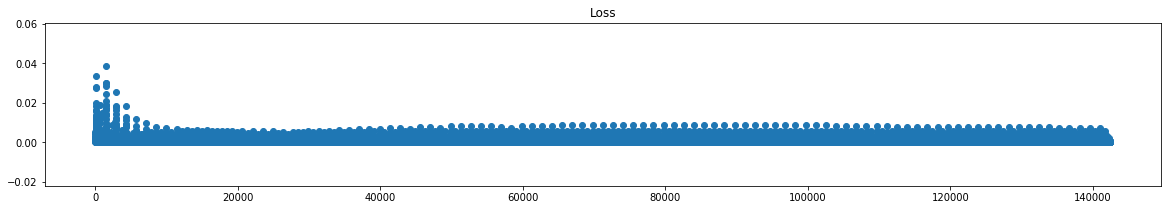

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

## Plot test results

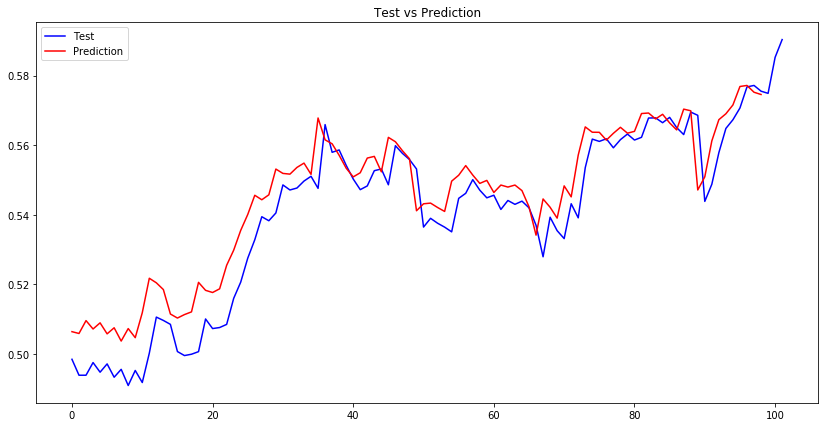

In [26]:
plt.figure(figsize=(14,7))
plt.plot(yTest,label='Test',color='blue')
plt.plot(test_pred_list,label='Prediction',color='red')
plt.title('Test vs Prediction')
plt.legend(loc='upper left')
plt.show()